# Working with CMIP6 data

Please see the link below:
CMIP6 in the Cloud Five Ways (https://medium.com/pangeo/cmip6-in-the-cloud-five-ways-96b177abe396)   
This example is from https://nbviewer.jupyter.org/github/pangeo-data/pangeo-cmip6-examples/blob/master/search_and_load_with_esgf_opendap.ipynb

### Search and Load CMIP6 Data via ESGF / OPeNDAP
This notebooks shows how to search and load data via Earth System Grid Federation infrastructure (https://esgf.llnl.gov). This infrastructure works great and is the foundation of the CMIP6 distribution system.

The main technologies used here are the ESGF search API(https://github.com/ESGF/esgf.github.io/wiki/ESGF_Search_REST_API), used to figure out what data we want, and OPeNDAP (https://www.opendap.org), a remote data access protocol over HTTP.

In [3]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

xr.set_options(display_style='html')
%matplotlib inline
%config InlineBackend.figure_format = 'retina' 

Built-in magic commands:   
https://ipython.readthedocs.io/en/stable/interactive/magics.html

In [4]:
plt.rcParams['figure.figsize'] = 12, 6

Customizing Matplotlib with style sheets and rcParams:   
https://matplotlib.org/stable/tutorials/introductory/customizing.html

### Search using ESGF API

In [20]:
#!/usr/bin/env python
from __future__ import print_function
import requests
import xml.etree.ElementTree as ET
import numpy

# Author: Unknown
# I got the original version from a word document published by ESGF
# https://docs.google.com/document/d/1pxz1Kd3JHfFp8vR2JCVBfApbsHmbUQQstifhGNdc6U0/edit?usp=sharing

# API AT: https://github.com/ESGF/esgf.github.io/wiki/ESGF_Search_REST_API#results-pagination

def esgf_search(server="https://esgf-node.llnl.gov/esg-search/search",
                files_type="OPENDAP", local_node=True, project="CMIP6",
                verbose=False, format="application%2Fsolr%2Bjson",
                use_csrf=False, **search):
    client = requests.session()
    payload = search
    payload["project"] = project
    payload["type"]= "File"
    if local_node:
        payload["distrib"] = "false"
    if use_csrf:
        client.get(server)
        if 'csrftoken' in client.cookies:
            # Django 1.6 and up
            csrftoken = client.cookies['csrftoken']
        else:
            # older versions
            csrftoken = client.cookies['csrf']
        payload["csrfmiddlewaretoken"] = csrftoken

    payload["format"] = format

    offset = 0
    numFound = 10000
    all_files = []
    files_type = files_type.upper()
    while offset < numFound:
        payload["offset"] = offset
        url_keys = [] 
        for k in payload:
            url_keys += ["{}={}".format(k, payload[k])]

        url = "{}/?{}".format(server, "&".join(url_keys))
        print(url)
        r = client.get(url)
        r.raise_for_status()
        resp = r.json()["response"]
        numFound = int(resp["numFound"])
        resp = resp["docs"]
        offset += len(resp)
        for d in resp:
            if verbose:
                for k in d:
                    print("{}: {}".format(k,d[k]))
            url = d["url"]
            for f in d["url"]:
                sp = f.split("|")
                if sp[-1] == files_type:
                    all_files.append(sp[0].split(".html")[0])
    return sorted(all_files)

In [7]:
result = esgf_search(activity_id='CMIP', table_id='Amon',
                     variable_id='tas', experiment_id='historical',
                     institution_id="NCAR", source_id="CESM2",
                     member_id="r10i1p1f1")

https://esgf-node.llnl.gov/esg-search/search/?activity_id=CMIP&table_id=Amon&variable_id=tas&experiment_id=historical&institution_id=NCAR&source_id=CESM2&member_id=r10i1p1f1&project=CMIP6&type=File&distrib=false&format=application%2Fsolr%2Bjson&offset=0
https://esgf-node.llnl.gov/esg-search/search/?activity_id=CMIP&table_id=Amon&variable_id=tas&experiment_id=historical&institution_id=NCAR&source_id=CESM2&member_id=r10i1p1f1&project=CMIP6&type=File&distrib=false&format=application%2Fsolr%2Bjson&offset=10


### Load Data with Xarray

In [21]:
# there are mulitple sources of the same data--need to pick one
files_to_open = result[-4:]

ds = xr.open_mfdataset(files_to_open, combine='by_coords')
ds

/Users/jungeunl/miniconda3/lib/python3.7/site-packages/xarray/conventions.py:500: SerializationWarning: variable 'tas' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  decode_timedelta=decode_timedelta,


<xarray.Dataset>
Dimensions:    (lat: 192, lon: 288, nbnd: 2, time: 1980)
Coordinates:
  * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time       (time) object 1850-01-15 12:00:00 ... 2014-12-15 12:00:00
Dimensions without coordinates: nbnd
Data variables:
    time_bnds  (time, nbnd) object dask.array<chunksize=(600, 2), meta=np.ndarray>
    lat_bnds   (time, lat, nbnd) float64 dask.array<chunksize=(600, 192, 2), meta=np.ndarray>
    lon_bnds   (time, lon, nbnd) float64 dask.array<chunksize=(600, 288, 2), meta=np.ndarray>
    tas        (time, lat, lon) float32 dask.array<chunksize=(600, 192, 288), meta=np.ndarray>
Attributes:
    Conventions:                     CF-1.7 CMIP-6.2
    activity_id:                     CMIP
    branch_method:                   standard
    branch_time_in_child:            674885.0
    branch_time_in_parent:           306600.0
    case_id:                         24
    cesm_casename:                   b.e21.BHIST.f09_g17.CMIP6-historical.010
    contact:                         cesm_cmip6@ucar.edu
    creation_date:                   2019-03-12T06:39:18Z
    data_specs_version:              01.00.29
    experiment:                      Simulation of recent past (1850 to 2014)...
    experiment_id:                   historical
    external_variables:              areacella
    forcing_index:                   1
    frequency:                       mon
    further_info_url:                https://furtherinfo.es-doc.org/CMIP6.NCA...
    grid:                            native 0.9x1.25 finite volume grid (192x...
    grid_label:                      gn
    initialization_index:            1
    institution:                     National Center for Atmospheric Research...
    institution_id:                  NCAR
    license:                         CMIP6 model data produced by <The Nation...
    mip_era:                         CMIP6
    model_doi_url:                   https://doi.org/10.5065/D67H1H0V
    nominal_resolution:              100 km
    parent_activity_id:              CMIP
    parent_experiment_id:            piControl
    parent_mip_era:                  CMIP6
    parent_source_id:                CESM2
    parent_time_units:               days since 0001-01-01 00:00:00
    parent_variant_label:            r1i1p1f1
    physics_index:                   1
    product:                         model-output
    realization_index:               10
    realm:                           atmos
    source:                          CESM2 (2017): atmosphere: CAM6 (0.9x1.25...
    source_id:                       CESM2
    source_type:                     AOGCM BGC
    sub_experiment:                  none
    sub_experiment_id:               none
    table_id:                        Amon
    tracking_id:                     hdl:21.14100/e47b79db-3925-45a7-9c0a-679...
    variable_id:                     tas
    variant_info:                    CMIP6 20th century experiments (1850-201...
    variant_label:                   r10i1p1f1
    DODS_EXTRA.Unlimited_Dimension:  time

Plot a map from a specific date.

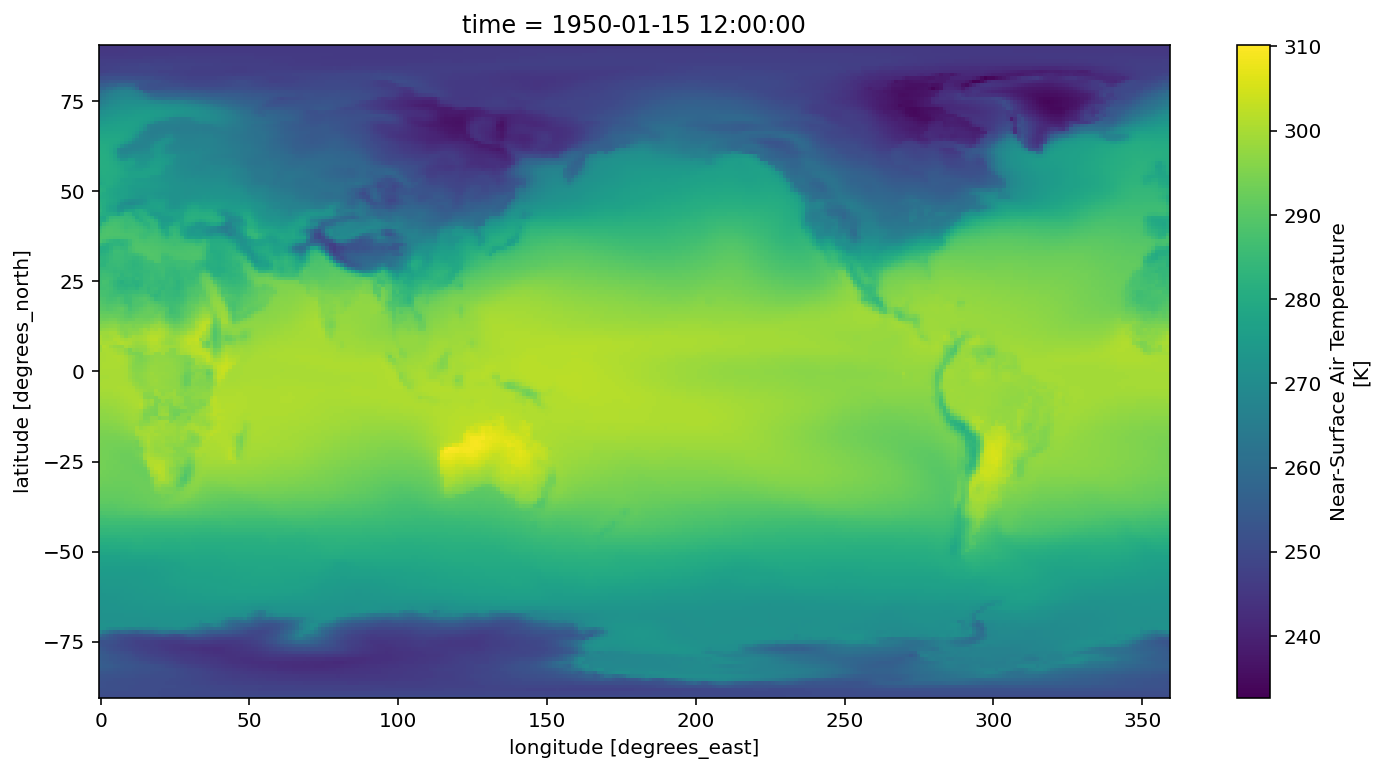

In [22]:
ds.tas.sel(time='1950-01').squeeze().plot()

### Calculating global average

First, let's read the area of each grid point. 

In [25]:
files_area = esgf_search(variable_id='areacella', activity_id='CMIP',
                         experiment_id='historical', institution_id="NCAR", source_id="CESM2")
ds_area = xr.open_dataset(files_area[0])

total_area = ds_area.areacella.sum(dim=['lon', 'lat'])   
ta_timeseries = (ds.tas * ds_area.areacella).sum(dim=['lon', 'lat']) / total_area  
ta_timeseries

https://esgf-node.llnl.gov/esg-search/search/?variable_id=areacella&activity_id=CMIP&experiment_id=historical&institution_id=NCAR&source_id=CESM2&project=CMIP6&type=File&distrib=false&format=application%2Fsolr%2Bjson&offset=0
https://esgf-node.llnl.gov/esg-search/search/?variable_id=areacella&activity_id=CMIP&experiment_id=historical&institution_id=NCAR&source_id=CESM2&project=CMIP6&type=File&distrib=false&format=application%2Fsolr%2Bjson&offset=10
https://esgf-node.llnl.gov/esg-search/search/?variable_id=areacella&activity_id=CMIP&experiment_id=historical&institution_id=NCAR&source_id=CESM2&project=CMIP6&type=File&distrib=false&format=application%2Fsolr%2Bjson&offset=20
https://esgf-node.llnl.gov/esg-search/search/?variable_id=areacella&activity_id=CMIP&experiment_id=historical&institution_id=NCAR&source_id=CESM2&project=CMIP6&type=File&distrib=false&format=application%2Fsolr%2Bjson&offset=30


/Users/jungeunl/miniconda3/lib/python3.7/site-packages/xarray/conventions.py:500: SerializationWarning: variable 'areacella' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  decode_timedelta=decode_timedelta,


<xarray.DataArray (time: 1980)>
dask.array<truediv, shape=(1980,), dtype=float32, chunksize=(600,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 1850-01-15 12:00:00 ... 2014-12-15 12:00:00

In [13]:
%time ta_timeseries.load()

CPU times: user 2.13 s, sys: 2.3 s, total: 4.43 s
Wall time: 49.2 s


<xarray.DataArray (time: 1980)>
array([284.99948, 285.23215, 285.85364, ..., 288.54376, 287.61884,
       287.06284], dtype=float32)
Coordinates:
  * time     (time) object 1850-01-15 12:00:00 ... 2014-12-15 12:00:00

#### xarray.Dataset.load:   
Manually trigger loading and/or computation of this dataset’s data from disk or a remote source into memory and return this dataset. Unlike compute, the original dataset is modified and returned.

Normally, it should not be necessary to call this method in user code, because all xarray functions should either work on deferred data or load data automatically. However, this method can be necessary when working with many file objects on disk.

Text(0.5, 1.0, 'Global Mean Surface Air Temperature')

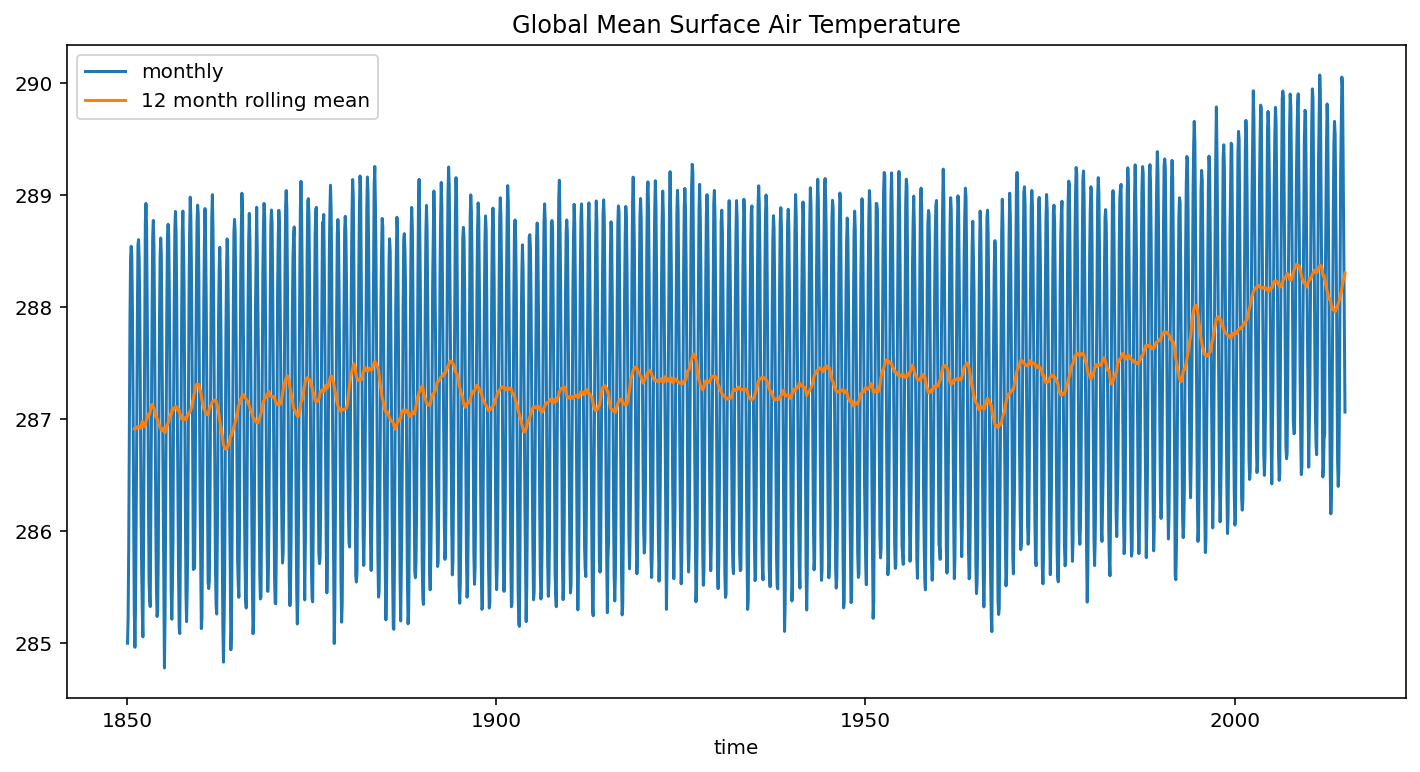

In [18]:
ta_timeseries.plot(label='monthly')
ta_timeseries.rolling(time=12).mean().plot(label='12 month rolling mean')
plt.legend()
plt.title('Global Mean Surface Air Temperature')

### Exercise
Read precipitation data from the same dataset and plot global mean precipitation over time.
Variable list is here:
https://pcmdi.llnl.gov/mips/cmip3/variableList.html